## Load Packages

In [80]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn import metrics
from scipy.stats import norm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from scipy.spatial.distance import cdist
from matplotlib.ticker import MaxNLocator
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_score

In [81]:
# function to calcualte percentage of default in each cluster
def get_default_prob(a):
    i = 0
    res = []
    while (i < len(a)):
        percent = 1-a[i]/(a[i]+a[i+1])
        res.append(percent)
        i += 2
    return res

## Load Data and Data Engineering

In [82]:
#load data
df = pd.read_csv("risk_data.csv")
df.head(3)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      139346       1         Cash loans           M            Y   
1      332581       1         Cash loans           F            N   
2      101245       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          450000.0   1042560.0      40702.5   
1               Y             2          112500.0    640080.0      31261.5   
2               Y             1          112500.0    314100.0      19215.0   

   AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         900000.0   Unaccompanied  Commercial associate   
1         450000.0   Unaccompanied               Working   
2         225000.0   Unaccompanied               Working   

             NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special            Married   Office apartment   
1  Secondary / secondary special            Married  House / apartment   
2  Secondary / secondary special     Civil marriage   Rented apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.014464      -16584          -9027            -4379.0   
1                    0.035792      -10307          -3184            -2268.0   
2                    0.006305       -8402           -570            -2736.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -131         24.0           1               1                0   
1            -2996          NaN           1               1                0   
2             -803          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           0           1             NaN              2.0   
1                 1           0           0             NaN              4.0   
2                 1           0           0  Security staff              3.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     2                            2   
2                     3                            3   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     MONDAY                        7   
1                    TUESDAY                       12   
2                    TUESDAY                        5   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       1   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       1                        1  Business Entity Type 2   
1                       1                        1  Business Entity Type 3   
2                       1                        1  Business Entity Type 3   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.333253      0.510890      0.340906             NaN               NaN   
1           NaN      0.548775      0.450747             NaN               NaN   
2           NaN      0.146112      0.380800             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                          NaN              NaN             NaN   
1                          NaN              NaN             NaN   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  

In [83]:
#describe data
df.describe()

SK_ID_CURR       TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count    5042.000000  5042.000000   5042.000000      5.042000e+03   
mean   279907.116224     0.086474      0.470250      1.773172e+05   
std    103244.272079     0.281090      0.720108      1.004194e+05   
min    100020.000000     0.000000      0.000000      3.510000e+04   
25%    190899.250000     0.000000      0.000000      1.125000e+05   
50%    279541.500000     0.000000      0.000000      1.575000e+05   
75%    369669.000000     0.000000      1.000000      2.205000e+05   
max    456248.000000     1.000000      4.000000      1.350000e+06   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  5.042000e+03    5042.000000     5.041000e+03   
mean   6.226787e+05   28181.309798     5.586754e+05   
std    4.155689e+05   15024.595611     3.806711e+05   
min    4.500000e+04    2673.000000     4.500000e+04   
25%    2.792925e+05   17077.500000     2.475000e+05   
50%    5.336685e+05   26217.000000     4.500000e+05   
75%    8.409960e+05   35937.000000     7.110000e+05   
max    2.700000e+06  225000.000000     2.700000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
count                 5042.000000   5042.000000    5042.000000   
mean                     0.021105 -14895.446648   -2395.756446   
std                      0.014095   3700.295126    2397.824075   
min                      0.000533 -25126.000000  -16121.000000   
25%                      0.010006 -17793.750000   -3184.750000   
50%                      0.018850 -14742.000000   -1649.000000   
75%                      0.028663 -11850.250000    -746.000000   
max                      0.072508  -7678.000000      -9.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
count        5042.000000      5042.000000  1897.000000      5042.0   
mean        -4705.280246     -2811.930980    12.255667         1.0   
std          3261.251558      1506.875724    12.102259         0.0   
min        -18294.000000     -6207.000000     0.000000         1.0   
25%         -7121.750000     -4172.750000     5.000000         1.0   
50%         -4288.000000     -2892.000000     9.000000         1.0   
75%         -1957.250000     -1521.000000    15.000000         1.0   
max             0.000000        -1.000000    65.000000         1.0   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE   FLAG_PHONE  \
count          5042.0      5042.000000       5042.000000  5042.000000   
mean              1.0         0.233439          0.998612     0.274296   
std               0.0         0.423061          0.037238     0.446203   
min               1.0         0.000000          0.000000     0.000000   
25%               1.0         0.000000          1.000000     0.000000   
50%               1.0         0.000000          1.000000     0.000000   
75%               1.0         0.000000          1.000000     1.000000   
max               1.0         1.000000          1.000000     1.000000   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  5042.000000      5042.000000           5042.000000   
mean      0.065252         2.214002              2.039072   
std       0.246994         0.905809              0.522705   
min       0.000000         1.000000              1.000000   
25%       0.000000         2.000000              2.000000   
50%       0.000000         2.000000              2.000000   
75%       0.000000         3.000000              2.000000   
max       1.000000         6.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                  5042.000000              5042.000000   
mean                      2.018842                12.270131   
std                       0.516963                 3.331934   
min                       1.000000                 0.000000   
25%                       2.000000                10.000000   
50%                       2.000000                12.000000   
75%              

In [84]:
#percentage of default customers
df[df.TARGET == 1].count()[0]/df.shape[0]

0.0864736215787386

In [85]:
# drop unnecessary columns
drop = ["SK_ID_CURR", "OWN_CAR_AGE", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG",	"YEARS_BUILD_AVG",	"COMMONAREA_AVG", "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG", 	"LANDAREA_AVG",	"LIVINGAPARTMENTS_AVG",	"LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG","APARTMENTS_MODE"	,"BASEMENTAREA_MODE",'YEARS_BEGINEXPLUATATION_MODE',	"YEARS_BUILD_MODE",	"COMMONAREA_MODE",	"ELEVATORS_MODE",	"ENTRANCES_MODE",	"FLOORSMAX_MODE",	"FLOORSMIN_MODE",	"LANDAREA_MODE",'LIVINGAPARTMENTS_MODE', 	"LIVINGAREA_MODE",	"NONLIVINGAPARTMENTS_MODE",	"NONLIVINGAREA_MODE",	"APARTMENTS_MEDI",	"BASEMENTAREA_MEDI",	"YEARS_BEGINEXPLUATATION_MEDI",	"YEARS_BUILD_MEDI",	"COMMONAREA_MEDI",	"ELEVATORS_MEDI",	"ENTRANCES_MEDI",	"FLOORSMAX_MEDI",	"FLOORSMIN_MEDI",	"LANDAREA_MEDI",	"LIVINGAPARTMENTS_MEDI",
"LIVINGAREA_MEDI",	"NONLIVINGAPARTMENTS_MEDI",	"NONLIVINGAREA_MEDI",	"TOTALAREA_MODE",	"OBS_30_CNT_SOCIAL_CIRCLE",	"DEF_30_CNT_SOCIAL_CIRCLE",	"OBS_60_CNT_SOCIAL_CIRCLE",	"DEF_60_CNT_SOCIAL_CIRCLE",	"DAYS_LAST_PHONE_CHANGE",	"FLAG_DOCUMENT_2",	"FLAG_DOCUMENT_3",	"FLAG_DOCUMENT_4",	"FLAG_DOCUMENT_5",	"FLAG_DOCUMENT_6",	"FLAG_DOCUMENT_7",	"FLAG_DOCUMENT_8",	"FLAG_DOCUMENT_9",	"FLAG_DOCUMENT_10",	"FLAG_DOCUMENT_11",	"FLAG_DOCUMENT_12",	"FLAG_DOCUMENT_13",	"FLAG_DOCUMENT_14",	"FLAG_DOCUMENT_15",	"FLAG_DOCUMENT_16",	"FLAG_DOCUMENT_17",	"FLAG_DOCUMENT_18",	"FLAG_DOCUMENT_19",	"FLAG_DOCUMENT_20",	"FLAG_DOCUMENT_21"]

df.drop(drop, axis=1, inplace=True)
drop_1 = ["APARTMENTS_AVG", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE", "OCCUPATION_TYPE", "FLAG_MOBIL", "FLAG_EMAIL"]
df.drop(drop_1, axis=1, inplace=True)
df = df.dropna()
df.shape

(4363, 38)

In [86]:
# divide numerical and categorical data
numeric_features = list(df.select_dtypes("float64").columns)
int_features = list(df.select_dtypes("int64").columns)
categorical_features = list(df.select_dtypes(include = ["category", "object"]).columns)
print(f'numeric_features:\n{numeric_features}\n\ncategorical_features:\n{categorical_features}')

numeric_features:
['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

categorical_features:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


In [87]:
df_numerical = df[numeric_features + int_features[1:7]]
df_categorical = df[categorical_features + int_features[0:1] + int_features[7:]]

In [88]:
# normalize data
df_numerical_norm  = (df_numerical-  df_numerical.min())/(df_numerical.max() - df_numerical.min())
df_numerical_norm

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0.315537    0.375729     0.171052         0.322034   
1             0.058864    0.224136     0.128588         0.152542   
2             0.058864    0.101356     0.074404         0.067797   
3             0.058864    0.066873     0.068231         0.059322   
5             0.134155    0.340420     0.113347         0.281356   
...                ...         ...          ...              ...   
5037          0.075975    0.178366     0.087378         0.157627   
5038          0.212868    0.639161     0.195239         0.569492   
5039          0.212868    0.288136     0.170141         0.288136   
5040          0.058864    0.050847     0.028458         0.050847   
5041          0.058864    0.072881     0.093066         0.072881   

      REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  CNT_FAM_MEMBERS  \
0                       0.193553           0.760757              0.2   
1                       0.489878           0.876169              0.6   
2                       0.080195           0.850582              0.4   
3                       0.076068           0.725603              0.6   
5                       0.112428           0.452299              0.2   
...                          ...                ...              ...   
5037                    0.334519           0.525067              0.0   
5038                    0.419896           0.264338              0.0   
5039                    0.251490           0.734405              0.2   
5040                    0.106940           0.747198              0.2   
5041                    0.390830           0.503198              0.2   

      AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
5                            0.0                        0.0   
...                          ...                        ...   
5037                         0.0                        0.0   
5038                         0.0                        0.0   
5039                         0.0                        0.0   
5040                         0.0                        0.0   
5041                         0.0                        0.0   

      AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
5                            0.0                        0.0   
...                          ...                        ...   
5037                         0.0                        0.0   
5038                         0.0                        0.0   
5039                         0.0                        0.0   
5040                         0.0                        0.0   
5041                         0.0                        0.0   

      AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  CNT_CHILDREN  \
0                           0.0                    0.090909          0.00   
1                           0.0                    0.454545          0.50   
2                           0.0                    0.090909          0.25   
3                           0.0                    0.272727          0.50   
5                           0.0                    0.272727          0.00   
...                         ...                         ...           ...   
5037                        0.4                    0.545455          0.00   
5038                        0.0                    0.363636          0.00   
5039                        0.0                    0.272727          0.00   
5040                        0.0         

{'whiskers': [<matplotlib.lines.Line2D at 0x2a954fd30>,
 'caps': [<matplotlib.lines.Line2D at 0x2a954f130>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a954ffd0>,
 'medians': [<matplotlib.lines.Line2D at 0x2abadb130>,
 'fliers': [<matplotlib.lines.Line2D at 0x2abadbe80>,
 'means': []}

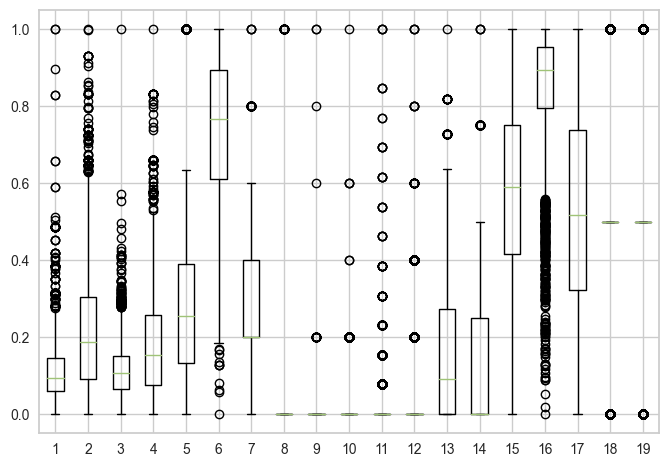

In [89]:
# draw boxplot
plt.boxplot(df_numerical_norm)

## PCA

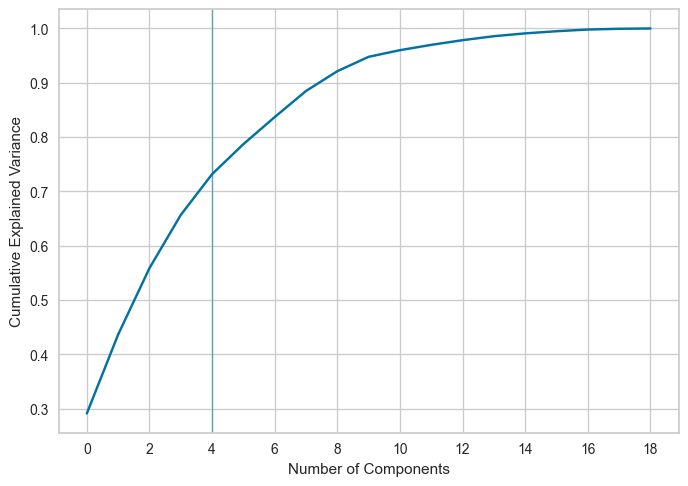

In [90]:
# figure out best value for PCA
ax = plt.figure().gca()
pca = PCA().fit(df_numerical_norm)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axvline(x=4, linewidth=1, color='b', alpha=0.5)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [91]:
# percentage of variance expalined by first 4 component
pca.explained_variance_ratio_[0:5].sum()

0.7318304774944356

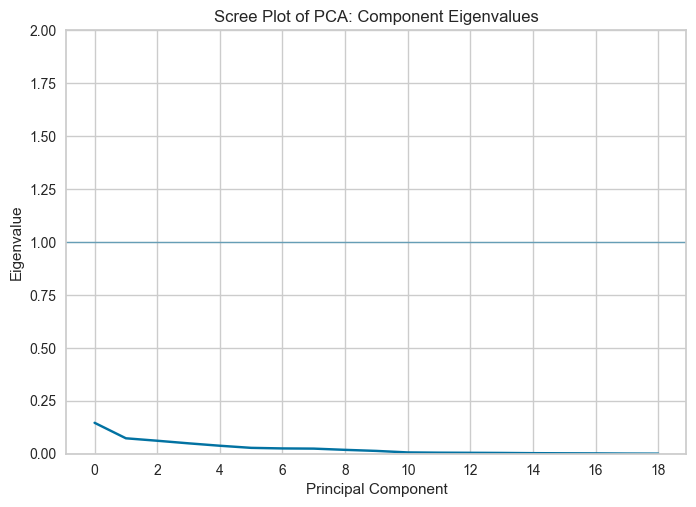

In [92]:
# scree plot
ax = plt.figure().gca()
ax.plot(pca.explained_variance_)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='b', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')
plt.ylim([0,2])
plt.show()

In [93]:
# we choose n components = 4
pca = PCA(n_components=4)
pca_fit = pca.fit_transform(df_numerical_norm)
df_pca = pd.DataFrame(data = pca_fit, columns = ['PC '+ str(i+1) for i in range(4)])
df_pca

PC 1      PC 2      PC 3      PC 4
0     0.032582 -0.276232 -0.249221  0.404993
1     0.032477  0.565170  0.021508  0.068403
2    -0.777444  0.307579 -0.395502  0.066953
3    -0.123978  0.507284 -0.325979  0.093631
4     0.016547 -0.174854  0.198669 -0.005575
...        ...       ...       ...       ...
4358  0.064557 -0.362209 -0.315565 -0.026940
4359  0.214240 -0.628443  0.338833  0.457467
4360  0.063566 -0.288168  0.361444  0.027421
4361 -0.068131  0.022893  0.122907 -0.354150
4362  0.076664 -0.280108  0.284071 -0.240647

[4363 rows x 4 columns]

## Kmeans

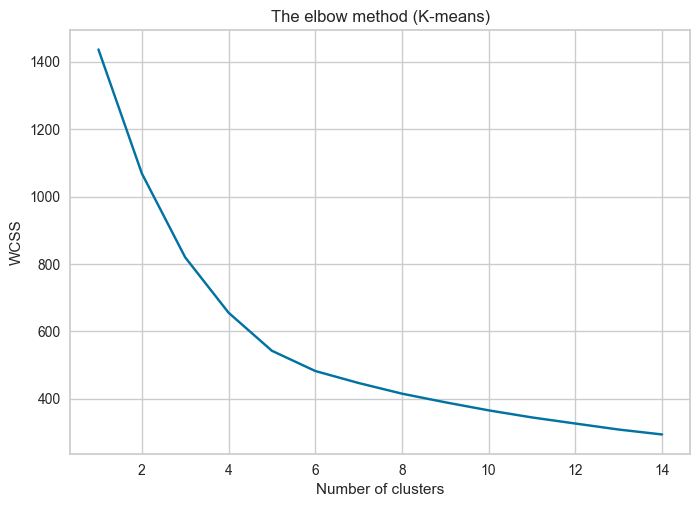

In [94]:
# plot wcss and find elbow point
wcss = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 15), wcss)
plt.title('The elbow method (K-means)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

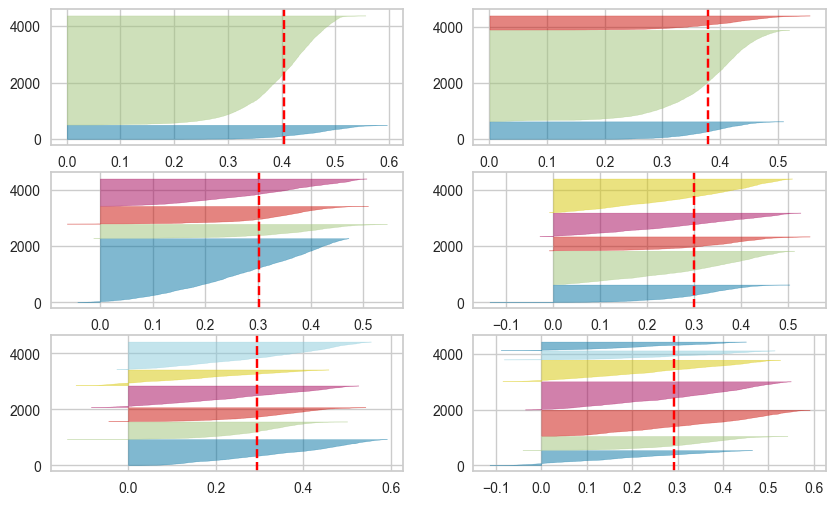

In [95]:
# draw Sihousette Visualization for K-mean
scores = ['cluster '+str(i)+': ' for i in range(2,8)]
fig, ax = plt.subplots(3, 2, figsize=(10,6))
for i in [2, 3, 4, 5, 6, 7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_pca)
    scores[i-2] += str(round(visualizer.silhouette_score_,2))

In [96]:
# output Sihousette score
scores

['cluster 2: 0.4',
 'cluster 3: 0.38',
 'cluster 4: 0.3',
 'cluster 5: 0.3',
 'cluster 6: 0.29',
 'cluster 7: 0.29']

In [97]:
# we choose n_clusters = 5 from Elbow Plot
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 428)
y_kmeans = kmeans.fit_predict(df_pca)

In [98]:
# get Davies–Bouldin index (DBI) Score (lower the better)
print("Davies–Bouldin index (DBI) is: ",davies_bouldin_score(df_pca, y_kmeans))

Davies–Bouldin index (DBI) is:  1.0858550658734518


In [99]:
# get Calinski-Harabasz index (higher the better)
print("Calinski-Harabasz index is: ",metrics.calinski_harabasz_score(df_pca, y_kmeans))

Calinski-Harabasz index is:  1795.1127446094126


In [100]:
# add cluster number to orginial data
df["cluster_kmean"] = y_kmeans

In [101]:
# get default ratio in each group for K-means
kmean_label = df.groupby("cluster_kmean")["TARGET"].value_counts().values

get_default_prob(kmean_label)

[0.11378205128205132,
 0.10307564422277637,
 0.07609988109393584,
 0.06934001670843781,
 0.04016064257028118]

## Hierarchical Clustering

### Try only numerical variables

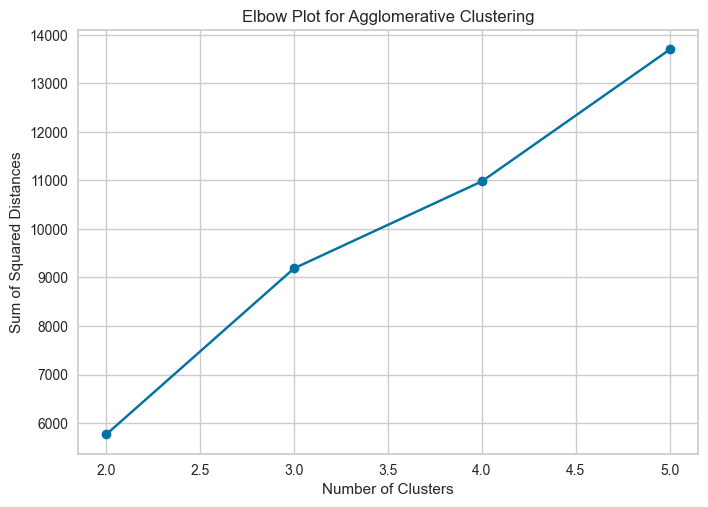

In [102]:
# Elbow Plot for Agglomerative Clustering
cluster_range = range(2, 6)

sum_of_squares = []
for n_clusters in cluster_range:
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(df_pca)
    clusters = model.labels_
    centers = []
    for i in range(n_clusters):
        centers.append(np.mean(df_pca[clusters == i], axis=0))
    sum_of_squares.append(np.sum(cdist(df_pca, centers, 'sqeuclidean')))

# Plot the elbow plot
plt.plot(cluster_range, sum_of_squares, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Plot for Agglomerative Clustering')
plt.show()

In [103]:
# fit model and make predication with n = 3
Z5 = AgglomerativeClustering(n_clusters=3, linkage='ward')

Z5.fit_predict(df_pca)
labels = Z5.labels_

In [104]:
# get Davies–Bouldin index (DBI) Score (lower the better)
print(davies_bouldin_score(df_pca, labels))

1.1317982013379286


In [105]:
# get Calinski-Harabasz index (higher the better)
print(metrics.calinski_harabasz_score(df_pca, labels))

1638.6340570745367


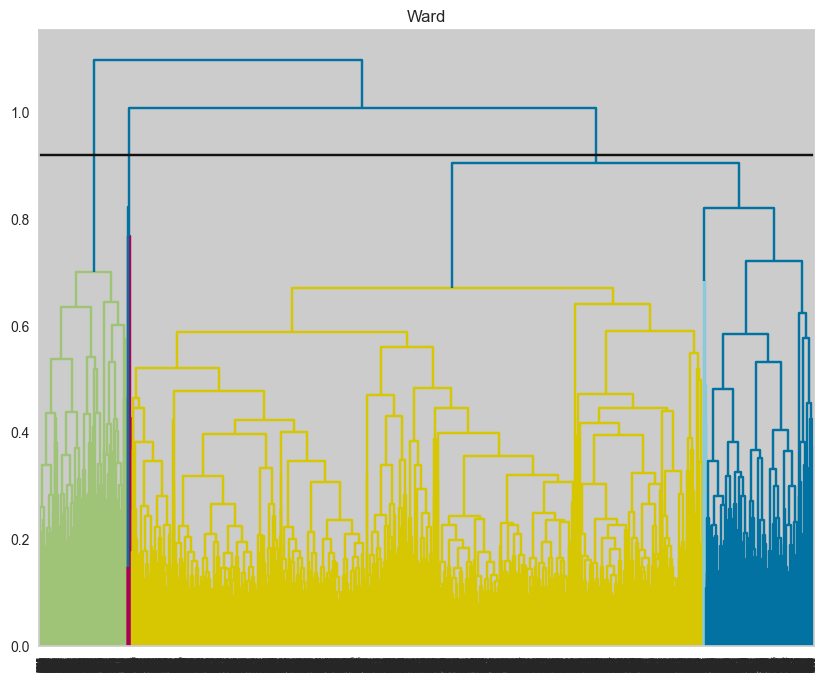

In [106]:
# Creating Dendrogram for our data with columns only numerical
# max_d = cut-off/ Threshold value
max_d = 0.92
Z5 = linkage(df_pca, method='average', metric='euclidean')
plt.figure(figsize=(10, 8))
dendrogram(Z5), plt.title('Ward')

# Cutting the dendrogram at max_d
plt.axhline(y=max_d, c='k')
plt.show()

In [107]:
# get default ratio in each group for hierarchy
df["cluster_hierarchy"] = labels
hierarchy_numeric_label = df.groupby("cluster_hierarchy")["TARGET"].value_counts().values

get_default_prob(hierarchy_numeric_label)

[0.08361616784942916, 0.04008016032064132, 0.1139646869983949]

## Try with both numerical and categorical variables

In [108]:
# Data Manipulation
df_categorical.drop(["TARGET"], axis = 1, inplace = True)
df_categorical_dum = pd.get_dummies(df_categorical)
df_pca_both = df_pca.reset_index(drop=True)
df_categorical_dum= df_categorical_dum.reset_index(drop=True)
df_concat_both = pd.concat([df_pca_both,df_categorical_dum],axis=1)
df_concat_both.head(3)

/var/folders/12/7k50dn215wv87vytmtwr239h0000gn/T/ipykernel_5107/3080941892.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PC 1      PC 2      PC 3      PC 4  HOUR_APPR_PROCESS_START  \
0  0.032582 -0.276232 -0.249221  0.404993                        7   
1  0.032477  0.565170  0.021508  0.068403                       12   
2 -0.777444  0.307579 -0.395502  0.066953                        5   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       1   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       1                        1   
1                       1                        1   
2                       1                        1   

   NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                              1                                   0   
1                              1                                   0   
2                              1                                   0   

   CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0              0              1               0               1   
1              1              0               1               0   
2              0              1               1               0   

   FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  NAME_TYPE_SUITE_Children  \
0                  0                  1                         0   
1                  0                  1                         0   
2                  0                  1                         0   

   NAME_TYPE_SUITE_Family  NAME_TYPE_SUITE_Group of people  \
0                       0                                0   
1                       0                                0   
2                       0                                0   

   NAME_TYPE_SUITE_Other_A  NAME_TYPE_SUITE_Other_B  \
0                        0                        0   
1                        0                        0   
2                        0                        0   

   NAME_TYPE_SUITE_Spouse, partner  NAME_TYPE_SUITE_Unaccompanied  \
0                                0                              1   
1                                0                              1   
2                                0                              1   

   NAME_INCOME_TYPE_Commercial associate  NAME_INCOME_TYPE_State servant  \
0                                      1                               0   
1                                      0                               0   
2                                      0                               0   

   NAME_INCOME_TYPE_Working  NAME_EDUCATION_TYPE_Academic degree  \
0                         0                                    0   
1                         1                                    0   
2                         1                                    0   

   NAME_EDUCATION_TYPE_Higher education  \
0                                     0   
1                                     0   
2                                     0   

   NAME_EDUCATION_TYPE_Incomplete higher  NAME_EDUCATION_TYPE_Lower secondary  \
0                                      0                                    0   
1                                      0                                    0   
2                                      0                                    0   

   NAME_EDUCATION_TYPE_Secondary / secondary special  \
0                                                  1   
1                                                  1   
2                                                  1   

   NAME_FAMILY_STATUS_Civil marriage  NAME_FAMILY_STATUS_Married  \
0                                  0                           1   
1           

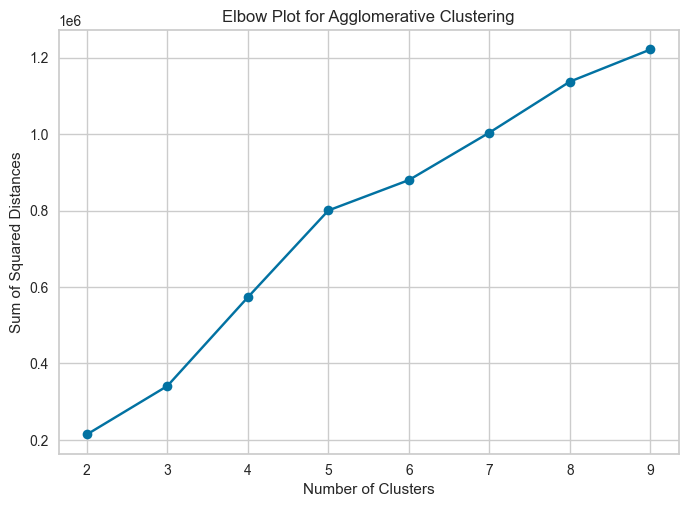

In [109]:
# Elbow Plot for Agglomerative Clustering

cluster_range = range(2, 10)

sum_of_squares = []
for n_clusters in cluster_range:
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(df_concat_both)
    clusters = model.labels_
    centers = []
    for i in range(n_clusters):
        centers.append(np.mean(df_concat_both[clusters == i], axis=0))
    sum_of_squares.append(np.sum(cdist(df_concat_both, centers, 'sqeuclidean')))

# Plot the elbow plot
plt.plot(cluster_range, sum_of_squares, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Plot for Agglomerative Clustering')
plt.show()

In [110]:
# fit model and make predication with n = 3
Z5 = AgglomerativeClustering(n_clusters=5, linkage='ward')

Z5.fit_predict(df_concat_both)
labels = Z5.labels_

In [111]:
# get Davies–Bouldin index (DBI) Score (lower the better)
print(davies_bouldin_score(df_concat_both, labels))

1.7882567684104522


In [112]:
# get Calinski-Harabasz index (higher the better)
print(metrics.calinski_harabasz_score(df_concat_both, labels))

1430.119889097635


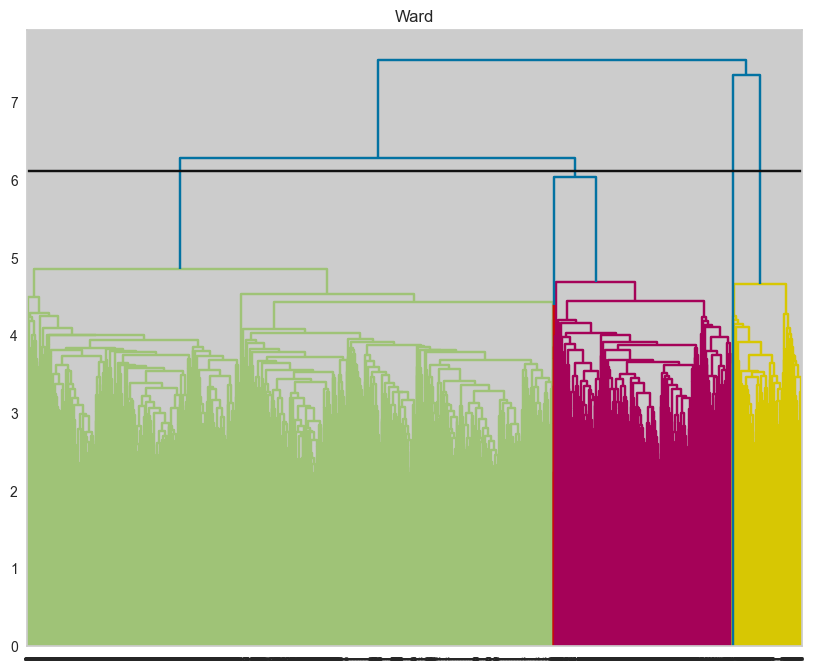

In [118]:
# Creating Dendrogram for our data with columns numerical and categorical
# max_d = cut-off/ Threshold value
max_d = 6.125
Z5 = linkage(df_concat_both, method='average', metric='euclidean')
plt.figure(figsize=(10, 8))
dendrogram(Z5,labels=labels), plt.title('Ward')

# Cutting the dendrogram at max_d
plt.axhline(y=max_d, c='k')
plt.show()

In [114]:
# get default ratio in each group for hierarchy
df["cluster_hierarchy_both"] = labels
hierarchy_both_label = df.groupby("cluster_hierarchy_both")["TARGET"].value_counts().values

get_default_prob(hierarchy_both_label)

[0.08276333789329682,
 0.08418740849194728,
 0.07669021190716452,
 0.1225806451612903,
 0.05128205128205132]

## KPrototypes

In [115]:
# Data Manipulation
df_categorical = df_categorical.astype(object)
df_categorical = df_categorical.reset_index(drop=True)

df_kp = pd.concat([df_pca,df_categorical],axis=1)
categorical_features = list(df_kp.select_dtypes(include = ["category", "object"]).columns)
cat_indices = [df_kp.columns.get_loc(col) for col in categorical_features]

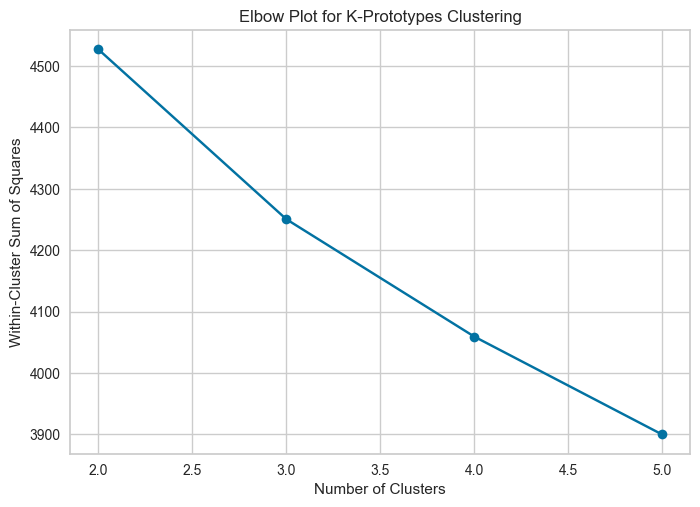

In [117]:
# Elbow Plot for Agglomerative Clustering
cluster_range = range(2, 6)

wcss = []
for n_clusters in cluster_range:
    model = KPrototypes(n_clusters=n_clusters)
    clusters = model.fit_predict(df_kp, categorical=cat_indices)
    wcss.append(model.cost_)

plt.plot(cluster_range, wcss, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Plot for K-Prototypes Clustering')
plt.show()

In [ ]:
df_kp

In [ ]:
# get kproto cluster with n = 4
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2, random_state= 123)
clusters = kproto.fit_predict(df_kp.values, categorical= cat_indices)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1458, ncost: 4156.399965422952
Run: 1, iteration: 2/100, moves: 449, ncost: 4139.88809617826
Run: 1, iteration: 3/100, moves: 314, ncost: 4100.038995126501
Run: 1, iteration: 4/100, moves: 292, ncost: 4075.056264945234
Run: 1, iteration: 5/100, moves: 242, ncost: 4061.4669455577696
Run: 1, iteration: 6/100, moves: 144, ncost: 4059.372629650957
Run: 1, iteration: 7/100, moves: 45, ncost: 4059.1575488933718
Run: 1, iteration: 8/100, moves: 17, ncost: 4059.125824626641
Run: 1, iteration: 9/100, moves: 8, ncost: 4059.1199391968403
Run: 1, iteration: 10/100, moves: 5, ncost: 4059.11780377971
Run: 1, iteration: 11/100, moves: 0, ncost: 4059.11780377971
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1314, ncost: 4213.651961276394
Run: 2, iter

In [ ]:
# get Davies–Bouldin index (DBI) Score (lower the better)
print(davies_bouldin_score(df_concat_both,clusters))

4.7004309119078655


In [ ]:
# get Calinski-Harabasz index (higher the better)
print(metrics.calinski_harabasz_score(df_concat_both, clusters))

116.93435650642714


In [ ]:
# get default ratio in each group for hierarchy
df["cluster_proto"] = clusters
kp_label = df.groupby("cluster_proto")["TARGET"].value_counts().values

get_default_prob(kp_label)

[0.08054260279779568,
 0.09708737864077666,
 0.0375782881002088,
 0.1070234113712375]

## Find the variable Importance for original variable on PCA

In [ ]:
# print column mean for pca components
pca.fit_transform(df_numerical_norm)
comps = pca.components_
# calculate the column means
column_means = np.mean(comps, axis=0)

print(column_means)

[ 4.73211742e-02  1.92366923e-01  6.71748960e-02  1.76419207e-01
  7.93202485e-02  1.30111012e-02  2.29042875e-01 -1.65612546e-03
 -1.44441852e-04 -4.78856581e-04  2.34229000e-03  1.41814553e-03
 -3.40125408e-02  2.14994695e-01  5.77411511e-05 -2.78879914e-02
 -1.43891768e-01 -1.53553321e-01 -1.54099229e-01]


In [ ]:
# rank the importance
names = numeric_features + int_features[1:7]
importances = []
for i in range(len(names)):
    importances.append((abs(column_means[i]),names[i]))
importances.sort(reverse=True)
importances

[(0.22904287526623443, 'CNT_FAM_MEMBERS'),
 (0.2149946945810164, 'CNT_CHILDREN'),
 (0.19236692259597407, 'AMT_CREDIT'),
 (0.17641920667306055, 'AMT_GOODS_PRICE'),
 (0.1540992289254719, 'REGION_RATING_CLIENT_W_CITY'),
 (0.15355332129843677, 'REGION_RATING_CLIENT'),
 (0.14389176797818368, 'DAYS_ID_PUBLISH'),
 (0.0793202485239641, 'REGION_POPULATION_RELATIVE'),
 (0.06717489600748928, 'AMT_ANNUITY'),
 (0.04732117417421164, 'AMT_INCOME_TOTAL'),
 (0.0340125408032067, 'AMT_REQ_CREDIT_BUREAU_YEAR'),
 (0.02788799143849013, 'DAYS_EMPLOYED'),
 (0.013011101242801516, 'DAYS_REGISTRATION'),
 (0.0023422900005102155, 'AMT_REQ_CREDIT_BUREAU_MON'),
 (0.0016561254611014602, 'AMT_REQ_CREDIT_BUREAU_HOUR'),
 (0.0014181455273443425, 'AMT_REQ_CREDIT_BUREAU_QRT'),
 (0.0004788565810852258, 'AMT_REQ_CREDIT_BUREAU_WEEK'),
 (0.00014444185163734401, 'AMT_REQ_CREDIT_BUREAU_DAY'),
 (5.774115112350958e-05, 'DAYS_BIRTH')]

## Creating Visualization Graph for PCA and Origin Variables for Different Methods

### PCA Clustering Plot

In [ ]:
# Create a trace for the scatter plot for K-mean
trace = go.Scatter3d(
    x=df_pca["PC 1"],
    y=df_pca["PC 2"],
    z=df_pca["PC 3"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_kmean"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(scene=dict(xaxis_title='PC 1', yaxis_title='PC 2', zaxis_title='PC 3'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
# Change the size of the figure
fig.update_layout(
    width=900, # Set the width of the figure to 800 pixels
    height=900 # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [ ]:
# Create a trace for the scatter plot for K-mean
trace = go.Scatter3d(
    x=df_pca["PC 1"],
    y=df_pca["PC 2"],
    z=df_pca["PC 4"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_kmean"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(scene=dict(xaxis_title='PC 1', yaxis_title='PC 2', zaxis_title='PC 4'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
# Change the size of the figure
fig.update_layout(
    width=1000, # Set the width of the figure to 800 pixels
    height=1000 # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [ ]:
# Create a trace for the scatter plot for K-mean
trace = go.Scatter3d(
    x=df_pca["PC 2"],
    y=df_pca["PC 3"],
    z=df_pca["PC 4"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_kmean"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(scene=dict(xaxis_title='PC 2', yaxis_title='PC 3', zaxis_title='PC 4'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
# Change the size of the figure
fig.update_layout(
    width=900, # Set the width of the figure to 800 pixels
    height=900 # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [ ]:
# Create a trace for the scatter plot for cluster_hierarchy
trace = go.Scatter3d(
    x=df_pca["PC 1"],
    y=df_pca["PC 2"],
    z=df_pca["PC 3"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_hierarchy"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(scene=dict(xaxis_title='PC 1', yaxis_title='PC 2', zaxis_title='PC 3'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
# Change the size of the figure
fig.update_layout(
    width=1000, # Set the width of the figure to 800 pixels
    height=1000 # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [ ]:
# Create a trace for the scatter plot for cluster_hierarchy
trace = go.Scatter3d(
    x=df_pca["PC 1"],
    y=df_pca["PC 2"],
    z=df_pca["PC 4"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_hierarchy"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(scene=dict(xaxis_title='PC 1', yaxis_title='PC 2', zaxis_title='PC 4'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
# Change the size of the figure
fig.update_layout(
    width=900, # Set the width of the figure to 800 pixels
    height=900 # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

In [ ]:
# Create a trace for the scatter plot for cluster_hierarchy
trace = go.Scatter3d(
    x=df_pca["PC 2"],
    y=df_pca["PC 3"],
    z=df_pca["PC 4"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_hierarchy"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(scene=dict(xaxis_title='PC 2', yaxis_title='PC 3', zaxis_title='PC 4'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
fig.update_layout(
    width=1000, # Set the width of the figure to 800 pixels
    height=1000 # Set the height of the figure to 600 pixels
)

# Show the plot
fig.show()

### K-mean Original Variable Plot

In [ ]:
# Create a trace for the scatter plot for K-mean
trace = go.Scatter3d(
    x=df["DAYS_EMPLOYED"]*-1/365,
    y=df["AMT_CREDIT"],
    z=df["AMT_INCOME_TOTAL"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_kmean"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# define the layout and set the axis names
fig.update_layout(title='3D Cluster Visualization for K-mean')
fig.update_layout(scene=dict(xaxis_title='Year Employed', yaxis_title='Credit Amount of Loans', zaxis_title='Income of Client'))
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))
# Change the size of the figure
fig.update_layout(
    width=1000, # Set the width of the figure to 800 pixels
    height=1000 # Set the height of the figure to 600 pixels
)
# Show the plot
fig.show()

### Hierarchical Clustering Original Variable Plot

In [ ]:
# Create a trace for the scatter plot for cluster_hierarchy
trace = go.Scatter3d(
    x=df["DAYS_EMPLOYED"]*-1/365,
    y=df["AMT_CREDIT"],
    z=df["AMT_INCOME_TOTAL"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_hierarchy"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)


# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)
fig.update_layout(title='3D Cluster Visualization for Hierarchy')
fig.update_layout(scene=dict(xaxis_title='Year Employed', yaxis_title='Credit Amount of Loans', zaxis_title='Income of Client'))

# Change the size of the figure
fig.update_layout(
    width=1000, # Set the width of the figure to 800 pixels
    height=1000 # Set the height of the figure to 600 pixels
)

# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))

# Show the plot
fig.show()

### Kproto Clustering Original Variable Plot

In [ ]:
# Create a trace for the scatter plot for cluster_proto
trace = go.Scatter3d(
    x=df["DAYS_EMPLOYED"]*-1/365,
    y=df["AMT_CREDIT"],
    z=df["AMT_INCOME_TOTAL"],
    mode='markers',
    marker=dict(
        size= 5,
        color=df["cluster_proto"],
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)


# Create a figure and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)
fig.update_layout(title='3D Cluster Visualization for Hierarchy')
fig.update_layout(scene=dict(xaxis_title='Year Employed', yaxis_title='Credit Amount of Loans', zaxis_title='Income of Client'))

# Change the size of the figure
fig.update_layout(
    width=1000, # Set the width of the figure to 800 pixels
    height=1000 # Set the height of the figure to 600 pixels
)
# Set the range of the y-axis
#fig.update_layout(scene=dict(xaxis=dict(range=[0, 0.6*10**6])))

# Show the plot
fig.show()